In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [139]:
# R&D...
import codecs

def export(file_name, text):
    print(text)
    with codecs.open(file_name, 'a', 'utf-8') as f:
        f.truncate(0)
        f.write(text)

In [140]:
sig_Li = 0.05

In [141]:
data = mipt.read_excel('data/5.5.1-stripped.xlsx', usecols=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13), header=(0,1))
data

Back            Pb                       Fe                         Al  \
         N      T      L   T       N    Li      L   T       N     Li       L   
0   3526.0   60.0   0.00  10  641276  0.00   0.00  10  643507   0.00    0.00   
1   7098.0  120.0   4.65  20  718829  4.65   9.95  20  740734   9.95   20.10   
2  10841.0  180.0   9.55  30  606177  4.90  19.95  30  637471  10.00   39.90   
3   3503.0   60.0  14.05  40  475507  4.50  29.95  40  485600  10.00   59.60   
4   7152.0  120.0  18.40  60  445987  4.35  40.05  60  421336  10.10   79.50   
5      NaN    NaN  23.20  60  263648  4.80  50.05  60  245765  10.00   99.50   
6      NaN    NaN  28.05  70  180240  4.85  60.25  70  165630  10.20  119.15   
7      NaN    NaN  32.85  80  126171  4.80  70.20  80  113871   9.95  139.10   
8      NaN    NaN  37.65  80   80038  4.80  79.90  80   70480   9.70  158.95   

                      
    T       N     Li  
0  10  646042   0.00  
1  20  878138  20.10  
2  30  883858  19.80  
3  40  788453  19.70  
4  60  792969  19.90  
5  60  537202  20.00  
6  70  428662  19.65  
7  80  335148  19.95  
8  80  232567  19.85

## Первичные экспериментальные данные

In [142]:
nfmt  = [r'$N$', '{:.0f}', 0]
snfmt  = [r'$\sigma_{N}$', '{:.0f}', 0]
tfmt  = [r'$T$, с', '{:.0f}', 0]
lfmt  = [r'$L$, мм', '{:.2f}', 0]
lifmt = [r'$L_i$, мм', '{:.2f}', 0]
slfmt = [r'$\sigma_{L}$, мм', '{:.2f}', 0]

sL = []
for st in range(0, len(data[('Pb', 'L')])):
    sL.append(sig_Li * math.sqrt((st + 1)))

data1 = pd.DataFrame(data["Back"].dropna())
fmt1 = {
    'T' : tfmt,
    'N' : nfmt,
    'sN' : snfmt,
}
data1.insert(1, 'sN', np.sqrt(data1['N']))
data[('Back', 'sN')] = np.sqrt(data1['N'])
tab = mipt.table(data1, fmt1)
tab.to_latex('gen/tab-fed1.tex')

datas = [
    pd.DataFrame(data["Pb"]),
    pd.DataFrame(data["Fe"]),
    pd.DataFrame(data["Al"])
]
fmt = {
    'Li' : lifmt,
    'L'  : lfmt,
    'N'  : nfmt,
    'T'  : tfmt,
    'sL' : slfmt,
    'sN' : snfmt,
}
elems = ('Pb', 'Fe', 'Al')
for st in range(0, len(datas)):
    _data = datas[st]
    _data.insert(1, "sL", sL)
    _data.insert(4, 'sN', np.sqrt(_data['N']))
    data[(elems[st], 'sL')] = sL
    data[(elems[st], 'sN')] = np.sqrt(_data['N'])
    tab = mipt.table(_data, fmt)
    tab.to_latex('gen/tab-fed{:d}.tex'.format(st + 2))

## Определение шума

In [143]:
noise = data['Back'].dropna()
n = noise['N'] / noise['T']## Определение шума
print(n)
NOISE = n.mean()
sig_NOISE = n.std()
print(math.sqrt( 1/(len(n) - 1) *np.sum((n - n.mean())**2) ))
export('gen/eq-noise.tex', 'n_{{\\text{{шум}}}} = {:.0f}\pm{:.0f},\\;\\;\\varepsilon = {:.1f}\\%'.format(n.mean(), n.std(), 100 * n.std() / n.mean()))

0    58.766667
1    59.150000
2    60.227778
3    58.383333
4    59.600000
dtype: float64
0.719424066635472
n_{\text{шум}} = 59\pm1,\;\;\varepsilon = 1.2\%


## Графики $N(T)$

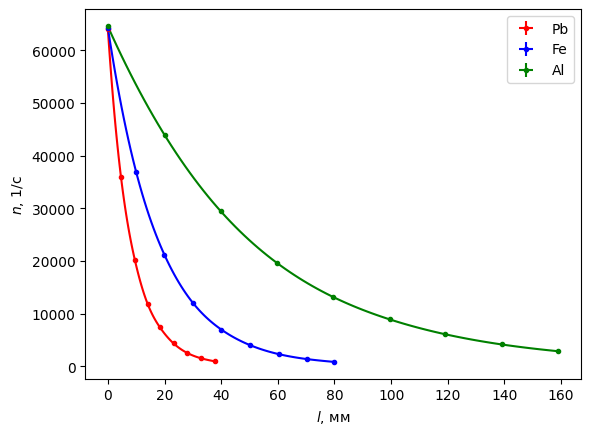

In [144]:
from scipy.interpolate import make_interp_spline

colors = ['red', 'blue', 'green']

for st in range(0, len(elems)):
    elem = elems[st]
    color = colors[st]

    nt = data[elem]['N'] / data[elem]['T'] 
    n = nt - NOISE
    eps_nt = data[elem]['sN'] / data[elem]['N']
    sig_nt = eps_nt * nt
    sig_n = np.sqrt(sig_nt**2 + sig_NOISE**2)

    l = data[elem]['L']
    sig_l = data[elem]['sL']
    
    x = np.linspace(l.min(), l.max(), 100)
    y = make_interp_spline(l, n)(x)

    plt.errorbar(l, n, label=elem, yerr=sig_n, xerr=sig_l, fmt='.', color=color)  
    plt.plot(x, y, '-', color=color)


plt.xlabel(r"$l$, мм")
plt.ylabel(r"$n$, 1/c")
plt.legend()

plt.savefig('gen/fig-nl.png')

\mu_{\text{Pb}} = 1.12\pm0.012 \;\;\text{см}^{-1}
\mu_{\text{Fe}} = 0.55\pm0.002 \;\;\text{см}^{-1}
\mu_{\text{Al}} = 0.20\pm0.001 \;\;\text{см}^{-1}


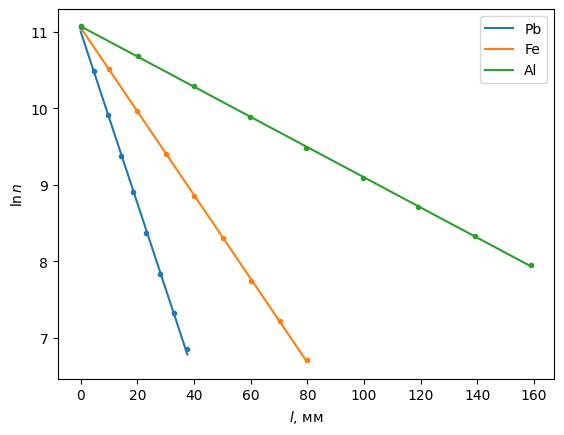

In [151]:
mus = {}
sig_mus = {}

elem = 'Pb'

for elem in ('Pb', 'Fe', 'Al'):

    nt = data[elem]['N'] / data[elem]['T'] 
    n = nt - NOISE
    eps_nt = data[elem]['sN'] / data[elem]['N']
    sig_nt = eps_nt * nt
    sig_n = np.sqrt(sig_nt**2 + sig_NOISE**2)

    lnn = np.log(n)
    sig_lnn = 1 / n * sig_n

    l = data[elem]['L']
    sig_l = data[elem]['sL']

    x, y, equ = mipt.plot(l, lnn, xerr = sig_l, yerr = sig_lnn, label=elem) 

    mnk = mipt.mnk(x, y)
    a = mnk.data['a'][0]
    da = mnk.data['da'][0]
        
    mus[elem] = -a*10
    sig_mus[elem] = da * 10

    export('gen/eq-{}.tex'.format(elem), '\\mu_{{\\text{{{}}}}} = {:.2f}\pm{:.3f} \\;\\;\\text{{см}}^{{-1}}'.format(elem, -a*10, da*10))

    
plt.xlabel(r"$l$, мм")
plt.ylabel(r"$\ln{n}$")
plt.legend()

plt.savefig('gen/fig-lnnl.png')

## Коэффициенты $\rho'$

In [149]:
rho = {
    'Pb' : 13.35, 
    'Fe' : 7.87, 
    'Al' : 2.7,
}

SyntaxError: invalid syntax (2141327263.py, line 7)

In [161]:
for elem in ('Pb', 'Fe', 'Al'):
    
    mus1 = mus[elem] / rho[elem]
    eps_mus = sig_mus[elem] / mus[elem]
    sig_mus1 = eps_mus * mus1

    print(r"$\mu'_{:s} = {:.4f} \pm {:.4f} \; \frac{{см^2}}{{г}}$\\".format(elem, mus1, sig_mus1))
    

$\mu'_Pb = 0.0839 \pm 0.0009 \; \frac{см^2}{г}$\\
$\mu'_Fe = 0.0695 \pm 0.0003 \; \frac{см^2}{г}$\\
$\mu'_Al = 0.0731 \pm 0.0003 \; \frac{см^2}{г}$\\
